Adapted from https://colab.research.google.com/drive/1b_cqXwjqH-uk_N7OdtdRv1_5lS9o2oJH
\
Found on https://paperswithcode.com/paper/modeling-framing-in-immigration-discourse-on

In [1]:
# !pip install transformers
# !pip install simpletransformers

In [2]:
from simpletransformers.classification import MultiLabelClassificationModel

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# If running on server with GPUs, can set use_cuda=True
model_generic = MultiLabelClassificationModel(model_type='roberta',model_name="juliamendelsohn/framing_issue_generic",use_cuda=False)
model_specific = MultiLabelClassificationModel(model_type='roberta',model_name="juliamendelsohn/framing_immigration_specific",use_cuda=False)
model_narrative = MultiLabelClassificationModel(model_type='roberta',model_name="juliamendelsohn/framing_narrative",use_cuda=False)

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /juliamendelsohn/framing_issue_generic/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000002374D3F3D50>, 'Connection to huggingface.co timed out. (connect timeout=10)'))"), '(Request ID: e1cc4c65-516e-4572-8387-ecc0cae49442)')' thrown while requesting HEAD https://huggingface.co/juliamendelsohn/framing_issue_generic/resolve/main/config.json
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /juliamendelsohn/framing_issue_generic/resolve/main/vocab.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000023774E3EDD0>, 'Connection to huggingface.co timed out. (connect timeout=10)'))"), '(Request ID: 69f5b56d-3a00-4115-a3ca-19eda58e3d18)')' thrown while requesting HEAD https://huggingface.co/juliamendelsohn/framing_issue_generic/resolve/main/vocab.jso

In [5]:
# All frame labels are in alphabetical order by category. We put these together with predictions to understand results
frames = {}
frames['Issue-Generic'] = ['Capacity and Resources', 'Crime and Punishment','Cultural Identity',
'Economic','External Regulation and Reputation', 'Fairness and Equality','Health and Safety',
'Legality, Constitutionality, Jurisdiction', 'Morality and Ethics','Policy Prescription and Evaluation',
'Political Factors and Implications', 'Public Sentiment','Quality of Life', 'Security and Defense']
frames['Issue-Specific'] = ['Hero: Cultural Diversity','Hero: Integration', 'Hero: Worker',
'Threat: Fiscal', 'Threat: Jobs', 'Threat: National Cohesion','Threat: Public Order',
'Victim: Discrimination','Victim: Global Economy', 'Victim: Humanitarian', 'Victim: War']
frames['Narrative'] = ['Episodic','Thematic']

In [6]:
models = {}
models['Issue-Generic'] = model_generic
models['Issue-Specific'] = model_specific
models['Narrative'] = model_narrative

Replace texts variable with collected data

In [10]:
top_index = ['Episodic', 
             'Security and Defense', 
             'External Regulation and Reputation', 
             'Health and Safety', 
             'Political Factors and Implications', 
             'Policy Prescription and Evaluation', 
             'Economic', 
             'Cultural Identity', 
             'Thematic', 
             'Crime and Punishment']

In [7]:
clustered_news_df = pd.read_csv('clustered_news_df.csv')
len(clustered_news_df)

3962

In [8]:
clustered_news_df.tail()

,datetime,url,title,owner_username,cluster_id,cosine_score
3957,2023-10-26 00:00:00,/2023/10/26/briefing/gaza-israel-house-speaker...,Thursday Briefing,NYTimes,news_14,0.965684
3958,2023-10-25 00:00:00,/2023/10/25/briefing/israel-gaza-house-speaker...,Wednesday Briefing,NYTimes,news_14,0.960250
3959,2023-10-24 00:00:00,/2023/10/24/briefing/gaza-israel-germany-polit...,Tuesday Briefing,NYTimes,news_14,0.968629
3960,2023-10-23 00:00:00,/2023/10/23/briefing/israel-gaza-ukraine.html?...,Monday Briefing,NYTimes,news_14,0.973560
3961,2023-10-20 00:00:00,/2023/10/20/briefing/biden-speech-gaza-russia-...,Friday Briefing,NYTimes,news_14,0.951302


### clustered_news_df
News Articles

In [9]:
clustered_news_df['cluster_id'].unique()

array(['news_10', 'news_18', 'news_21', 'news_1', 'news_16', 'news_8',
       'news_3', 'news_13', 'news_15', 'news_0', 'news_19', 'news_2',
       'news_17', 'news_12', 'news_4', 'news_9', 'news_5', 'news_7',
       'news_6', 'news_22', 'news_20', 'news_11', 'news_14'], dtype=object)

In [11]:
clustered_news_df[clustered_news_df['cluster_id'] == 'news_10']

,datetime,url,title,owner_username,cluster_id,cosine_score
0,2023-11-15 22:34:00,https://www.wsj.com/world/middle-east/israel-h...,Israel Says It Found Evidence of Hamas Activit...,WSJ,news_10,0.817253
1,2023-11-15 17:20:00,https://www.wsj.com/world/middle-east/u-s-reli...,U.S. Relied on Intercepts in Assessing Hamas’s...,WSJ,news_10,0.788720
2,2023-11-15 14:03:00,https://www.wsj.com/world/middle-east/u-s-pres...,U.S. Presses for Hamas to Release Hostages as ...,WSJ,news_10,0.845201
3,2023-11-12 00:04:00,https://www.wsj.com/world/middle-east/hamas-ne...,Hamas Needed a New Way to Get Money From Iran....,WSJ,news_10,0.575903
4,2023-11-10 20:44:00,https://www.wsj.com/world/middle-east/israel-r...,Israel Races to Root Out Hamas as Calls for Ga...,WSJ,news_10,0.794722
...,...,...,...,...,...,...
302,2023-10-18 14:34:00,/article/idUSL1N3BO2KP,UPDATE 1-US lawmakers urge White House crack d...,Reuters,news_10,0.638457
303,2023-10-18 09:39:00,/article/idUSKBN31I119,Disinformation surge threatens to fuel Israel-...,Reuters,news_10,0.628663
304,2023-10-18 06:16:00,/article/idUSL8N3BH47Y,Israel must decide how long anti-Hamas operati...,Reuters,news_10,0.659131
305,2023-10-18 03:32:00,/article/idUSKBN31E0D3,SNAPSHOT-Israel and Hamas at war: Latest news,Reuters,news_10,0.746618


In [16]:
def eval_framing(input_df):
    
    if len(input_df['cluster_id'].unique()) != 1:
        print('Select one cluster from the dataframe.')
        return
    
    cluster_id = input_df['cluster_id'].unique()[0]
    
    #Example messages about immigration (not from our dataset)
    texts = []
    owner_usernames = []
    
    for index, row in input_df.iterrows():
        texts.append(row['title'])
        owner_usernames.append(row['owner_username'])
    
    
    #Loops through all 3 frame types (Issue-Generic, Issue-Specific, Narrative)
    #Produces list of Pandas dataframes (for each frame type) with binary indicator for if a frame is detected
    dfs = []
    for frame_type in frames.keys():
        frame_labels = frames[frame_type]
        predictions, raw_outputs = models[frame_type].predict(texts)  #This is where we do multilabel frame classification
        new_df = pd.DataFrame(predictions)
        new_df.columns = frame_labels
        new_df['Text'] = texts
        new_df = new_df.set_index('Text')
        dfs.append(new_df)
        
    
    #Just aggregating all 3 frame types
    df = pd.concat(dfs,axis=1)
    df.head()
    
    
    df['owner_username'] = owner_usernames
    # df.to_csv('df_framing_news.csv', index=False)
    
    
    df_top10 = df.groupby(by='owner_username').mean()[top_index]
    
    
    plt.gcf().set_dpi(150)

    for index, row in df_top10.iterrows():
        if index == "NYTimes":
            color = 'blue'
        elif index == "WSJ":
            color = 'green'
        elif index == "Reuters":
            color = 'orange'
        
        media_id = index
        label = media_id + ' - news - ' + cluster_id
        plt.plot(row.values, color=color, label=label)
        plt.xticks(np.arange(0, 10, step=1))
        plt.xticks(np.arange(0, 10, step=1), top_index, rotation=90)

    plt.legend()
    
    
    return df_top10

In [30]:
clustered_news_df[clustered_news_df['cluster_id'] == 'news_10']

,datetime,url,title,owner_username,cluster_id,cosine_score
0,2023-11-15 22:34:00,https://www.wsj.com/world/middle-east/israel-h...,Israel Says It Found Evidence of Hamas Activit...,WSJ,news_10,0.817253
1,2023-11-15 17:20:00,https://www.wsj.com/world/middle-east/u-s-reli...,U.S. Relied on Intercepts in Assessing Hamas’s...,WSJ,news_10,0.788720
2,2023-11-15 14:03:00,https://www.wsj.com/world/middle-east/u-s-pres...,U.S. Presses for Hamas to Release Hostages as ...,WSJ,news_10,0.845201
3,2023-11-12 00:04:00,https://www.wsj.com/world/middle-east/hamas-ne...,Hamas Needed a New Way to Get Money From Iran....,WSJ,news_10,0.575903
4,2023-11-10 20:44:00,https://www.wsj.com/world/middle-east/israel-r...,Israel Races to Root Out Hamas as Calls for Ga...,WSJ,news_10,0.794722
...,...,...,...,...,...,...
302,2023-10-18 14:34:00,/article/idUSL1N3BO2KP,UPDATE 1-US lawmakers urge White House crack d...,Reuters,news_10,0.638457
303,2023-10-18 09:39:00,/article/idUSKBN31I119,Disinformation surge threatens to fuel Israel-...,Reuters,news_10,0.628663
304,2023-10-18 06:16:00,/article/idUSL8N3BH47Y,Israel must decide how long anti-Hamas operati...,Reuters,news_10,0.659131
305,2023-10-18 03:32:00,/article/idUSKBN31E0D3,SNAPSHOT-Israel and Hamas at war: Latest news,Reuters,news_10,0.746618


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

,Episodic,Security and Defense,External Regulation and Reputation,Health and Safety,Political Factors and Implications,Policy Prescription and Evaluation,Economic,Cultural Identity,Thematic,Crime and Punishment
owner_username,,,,,,,,,,
NYTimes,0.956204,0.839416,0.138686,0.175182,0.182482,0.109489,0.051095,0.065693,0.058394,0.080292
Reuters,0.989362,0.829787,0.308511,0.127660,0.276596,0.212766,0.085106,0.074468,0.010638,0.148936
WSJ,0.868421,0.802632,0.118421,0.105263,0.105263,0.223684,0.092105,0.026316,0.171053,0.092105


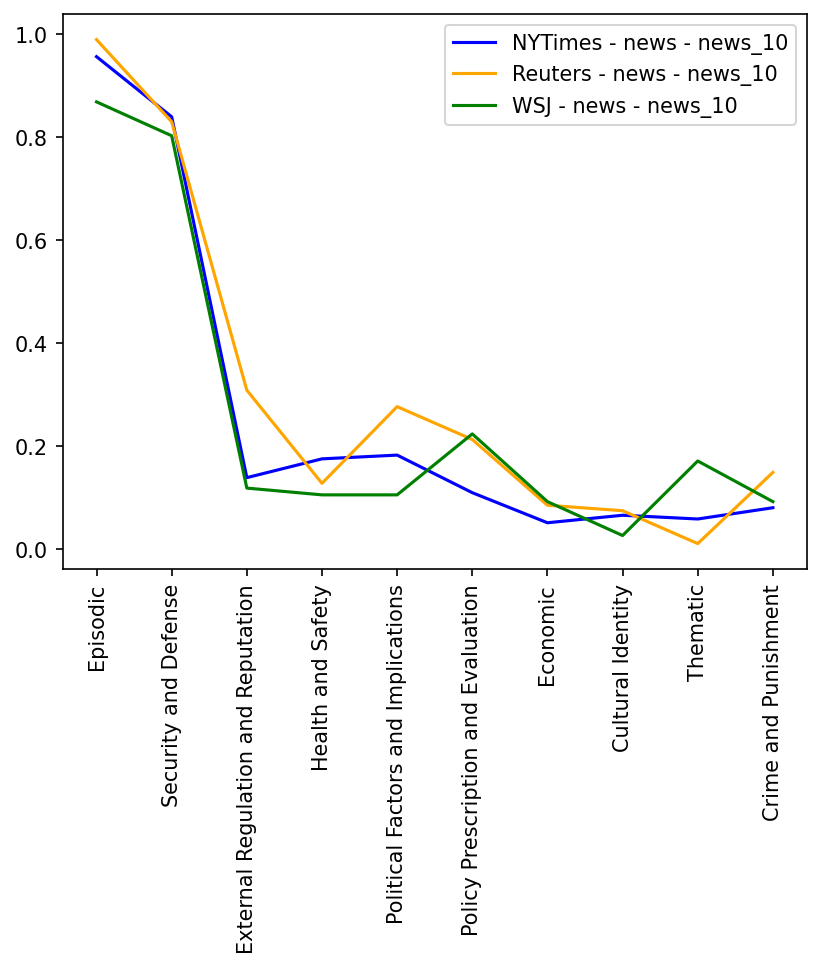

In [17]:
eval_framing(clustered_news_df[clustered_news_df['cluster_id'] == 'news_10'])

In [31]:
clustered_news_df[clustered_news_df['cluster_id'] == 'news_18']

,datetime,url,title,owner_username,cluster_id,cosine_score
307,2023-11-15 18:36:00,https://www.wsj.com/articles/u-s-executive-bra...,Opinion: Joe Biden Faces a Deep State Revolt,WSJ,news_18,0.696220
308,2023-11-13 18:16:00,https://www.wsj.com/world/uk/david-cameron-mak...,David Cameron Makes Surprise Return to U.K. Go...,WSJ,news_18,0.259616
309,2023-11-13 18:13:00,https://www.wsj.com/articles/obamas-lesson-for...,Opinion: Obama’s Lesson for Rashida Tlaib,WSJ,news_18,0.477578
310,2023-11-09 16:15:00,https://www.wsj.com/politics/elections/democra...,Democrats Grow More Confident in Campaign Mess...,WSJ,news_18,0.653598
311,2023-11-08 18:29:00,https://www.wsj.com/articles/notable-quotable-...,"Opinion: Notable & Quotable: Glenn Kessler, Jo...",WSJ,news_18,0.549652
...,...,...,...,...,...,...
408,2023-11-01 17:23:00,/article/idUSL1N3C23B1,UPDATE 1-Biden kicks off rural America tour in...,Reuters,news_18,0.553441
409,2023-10-25 20:25:00,/article/idUSKBN31P0XQ,Republican Mike Johnson elected US House speak...,Reuters,news_18,0.413067
410,2023-10-24 18:38:00,/article/idUSKBN31O274,Detained WSJ reporter's sister urges Biden to ...,Reuters,news_18,0.429037
411,2023-10-20 11:49:00,/article/idUSKBN31K1DJ,Factbox-What's in Biden's $106 billion supplem...,Reuters,news_18,0.551755


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

,Episodic,Security and Defense,External Regulation and Reputation,Health and Safety,Political Factors and Implications,Policy Prescription and Evaluation,Economic,Cultural Identity,Thematic,Crime and Punishment
owner_username,,,,,,,,,,
NYTimes,0.931507,0.123288,0.027397,0.054795,0.972603,0.082192,0.082192,0.027397,0.082192,0.068493
Reuters,1.000000,0.066667,0.200000,0.000000,1.000000,0.066667,0.200000,0.200000,0.000000,0.066667
WSJ,1.000000,0.166667,0.055556,0.000000,0.944444,0.166667,0.000000,0.000000,0.000000,0.000000


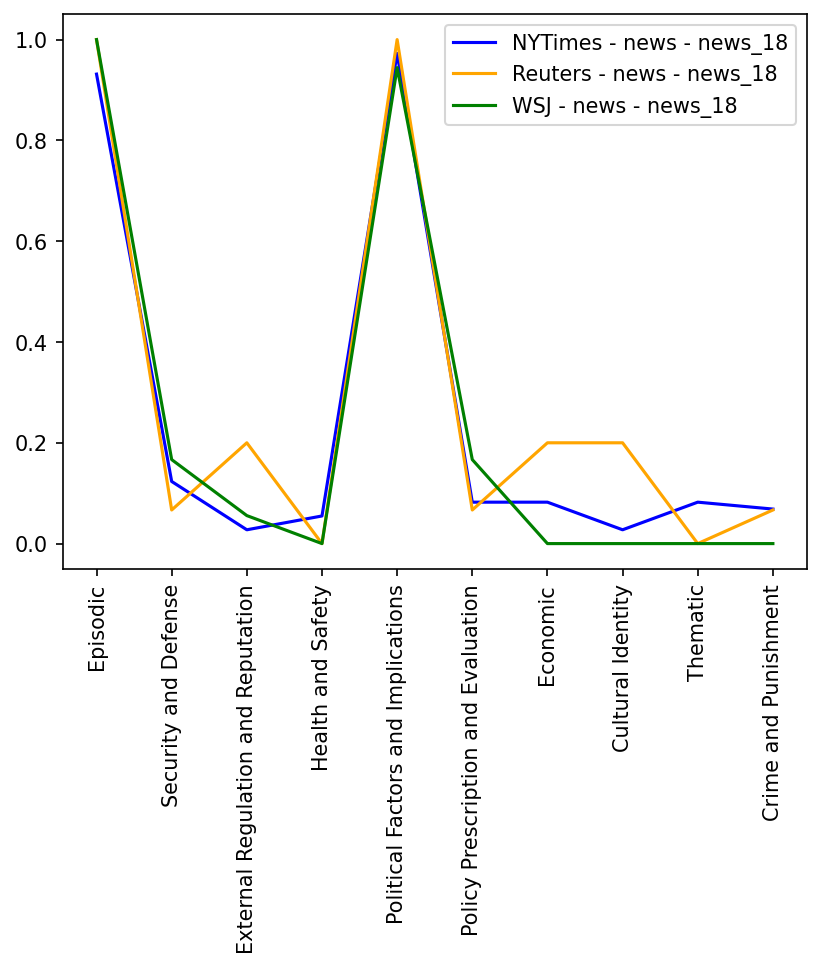

In [20]:
eval_framing(clustered_news_df[clustered_news_df['cluster_id'] == 'news_18'])

In [32]:
clustered_news_df[clustered_news_df['cluster_id'] == 'news_21']

,datetime,url,title,owner_username,cluster_id,cosine_score
413,2023-11-15 18:11:00,https://www.wsj.com/articles/the-first-humanit...,Opinion: Gaza Is the First Humanitarian-Crisis...,WSJ,news_21,0.856185
414,2023-11-15 07:02:00,https://www.wsj.com/world/middle-east/a-missio...,The U.N. Is Central to Life in Gaza. Now Its M...,WSJ,news_21,0.748108
415,2023-11-13 13:58:00,https://www.wsj.com/articles/the-west-should-w...,Opinion: The West Should Welcome Gaza Refugees,WSJ,news_21,0.694969
416,2023-11-11 00:48:00,https://www.wsj.com/world/middle-east/mistrust...,Push to Free Israeli Hostages in Gaza Hindered...,WSJ,news_21,0.823892
417,2023-11-10 18:40:00,https://www.wsj.com/articles/israeli-control-i...,Opinion: Israeli Control Is the Least Bad Opti...,WSJ,news_21,0.778355
...,...,...,...,...,...,...
696,2023-10-19 15:02:00,/article/idUSL1N3BO35Q,Verificación-Video capta ataque a edificio de ...,Reuters,news_21,0.564693
697,2023-10-19 12:58:00,/article/idUSKBN31I1XG,Israel's endgame? No sign of post-war plan for...,Reuters,news_21,0.751335
698,2023-10-19 08:38:00,/article/idUSKBN31J1AF,Gaza turmoil’s repercussions extend far and wide,Reuters,news_21,0.859019
699,2023-10-18 17:16:00,/article/idUSKBN31I1I5,Gaza blast stirs protests across Middle East a...,Reuters,news_21,0.667008


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

,Episodic,Security and Defense,External Regulation and Reputation,Health and Safety,Political Factors and Implications,Policy Prescription and Evaluation,Economic,Cultural Identity,Thematic,Crime and Punishment
owner_username,,,,,,,,,,
NYTimes,0.866667,0.644444,0.161111,0.227778,0.061111,0.172222,0.077778,0.066667,0.205556,0.011111
Reuters,0.621212,0.575758,0.212121,0.196970,0.136364,0.196970,0.075758,0.106061,0.409091,0.000000
WSJ,0.857143,0.666667,0.166667,0.261905,0.023810,0.333333,0.047619,0.119048,0.119048,0.023810


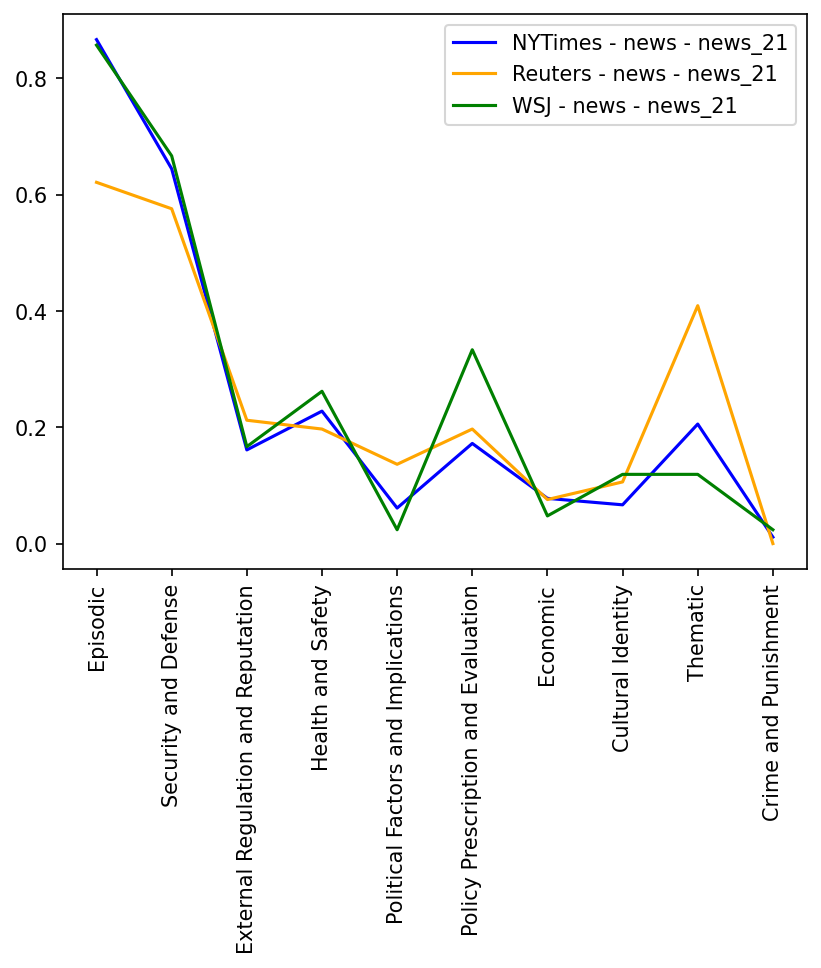

In [21]:
eval_framing(clustered_news_df[clustered_news_df['cluster_id'] == 'news_21'])

In [33]:
clustered_news_df[clustered_news_df['cluster_id'] == 'news_1']

,datetime,url,title,owner_username,cluster_id,cosine_score
701,2023-11-15 18:09:00,https://www.wsj.com/articles/my-gazan-friend-i...,Opinion: My Gazan Friend Is Dead,WSJ,news_1,0.430565
702,2023-11-11 00:01:00,https://www.wsj.com/world/middle-east/student-...,A Foreign Student Saved His Friends From Hamas...,WSJ,news_1,0.693790
703,2023-11-10 17:25:00,https://www.wsj.com/articles/the-scenes-of-gen...,Opinion: The Scenes of Genocide I Saw in Israe...,WSJ,news_1,0.618550
704,2023-11-08 00:52:00,https://www.wsj.com/world/china-and-russia-cla...,China and Russia Claim Moral High Ground Over ...,WSJ,news_1,0.594020
705,2023-10-28 09:47:00,https://www.wsj.com/world/middle-east/palestin...,Palestinian Death Statistics Remain a Subject ...,WSJ,news_1,0.640507
...,...,...,...,...,...,...
879,2023-10-19 17:10:00,/article/idUSKBN31J1D8,Israelis ink the memory of deadly attacks onto...,Reuters,news_1,0.545420
880,2023-10-19 15:00:00,/article/idUSL1N3BP2OM,Fact Check-Video captures Gaza building attack...,Reuters,news_1,0.604210
881,2023-10-19 13:33:00,/article/idUSKBN31J1WV,Israel estimates 200 hostages including 30 min...,Reuters,news_1,0.614876
882,2023-10-18 13:00:00,/article/idUSL1N3BO2CC,Fact Check-Video of boy crying dates to 2014 i...,Reuters,news_1,0.452267


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

,Episodic,Security and Defense,External Regulation and Reputation,Health and Safety,Political Factors and Implications,Policy Prescription and Evaluation,Economic,Cultural Identity,Thematic,Crime and Punishment
owner_username,,,,,,,,,,
NYTimes,0.930435,0.356522,0.034783,0.469565,0.043478,0.034783,0.026087,0.226087,0.069565,0.243478
Reuters,0.964286,0.410714,0.017857,0.571429,0.071429,0.000000,0.000000,0.482143,0.053571,0.267857
WSJ,1.000000,0.250000,0.083333,0.750000,0.083333,0.000000,0.000000,0.333333,0.000000,0.083333


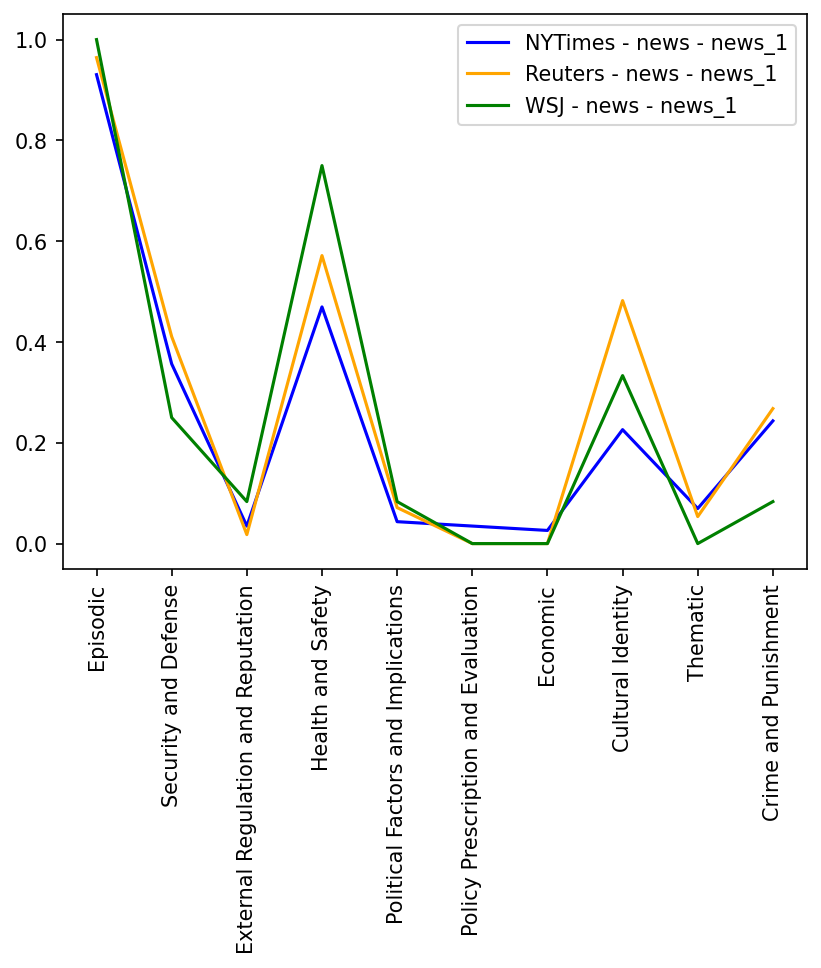

In [22]:
eval_framing(clustered_news_df[clustered_news_df['cluster_id'] == 'news_1'])

In [34]:
clustered_news_df[clustered_news_df['cluster_id'] == 'news_16']

,datetime,url,title,owner_username,cluster_id,cosine_score
884,2023-11-15 17:39:00,https://www.wsj.com/articles/all-is-quiet-in-o...,Opinion: All Is Quiet in Oil Markets—for Now,WSJ,news_16,0.616962
885,2023-11-08 13:33:00,https://www.wsj.com/world/americas/qatar-pursu...,Qatar Pursues Oil Deal After Brokering End to ...,WSJ,news_16,0.574688
886,2023-10-15 16:43:00,https://www.wsj.com/articles/echoes-of-the-197...,Opinion: Echoes of the 1973 Oil Crisis,WSJ,news_16,0.505246
887,2023-10-13 07:35:00,https://www.wsj.com/business/energy-oil/the-oi...,The Oil Price Has a Safety Valve. Gas Doesn’t.,WSJ,news_16,0.520945
888,2023-10-09 10:18:00,https://www.wsj.com/world/middle-east/oil-pric...,Oil Prices Don’t Need War in the Middle East t...,WSJ,news_16,0.717500
...,...,...,...,...,...,...
962,2023-10-18 15:15:00,/article/idUSKBN31I01X,"Oil up about 2% on big US crude storage draw, ...",Reuters,news_16,0.711787
963,2023-10-18 15:15:00,/article/idUSL1N3BO037,UPDATE 10-Oil up about 2% on big US crude stor...,Reuters,news_16,0.710737
964,2023-10-18 07:37:00,/article/idUSL1N3BO116,"GLOBAL MARKETS-Shares fall, Middle East strife...",Reuters,news_16,0.611475
965,2023-10-18 04:28:00,/article/idUSL4N3BM2IS,GRAPHIC-Uneasy calm in markets as Middle East ...,Reuters,news_16,0.576609


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

,Episodic,Security and Defense,External Regulation and Reputation,Health and Safety,Political Factors and Implications,Policy Prescription and Evaluation,Economic,Cultural Identity,Thematic,Crime and Punishment
owner_username,,,,,,,,,,
NYTimes,0.714286,0.142857,0.428571,0.142857,0.000000,0.142857,1.000000,0.000000,0.285714,0.0
Reuters,0.915493,0.112676,0.323944,0.056338,0.084507,0.225352,0.830986,0.070423,0.140845,0.0
WSJ,0.800000,0.200000,0.200000,0.200000,0.000000,0.200000,1.000000,0.000000,0.400000,0.0


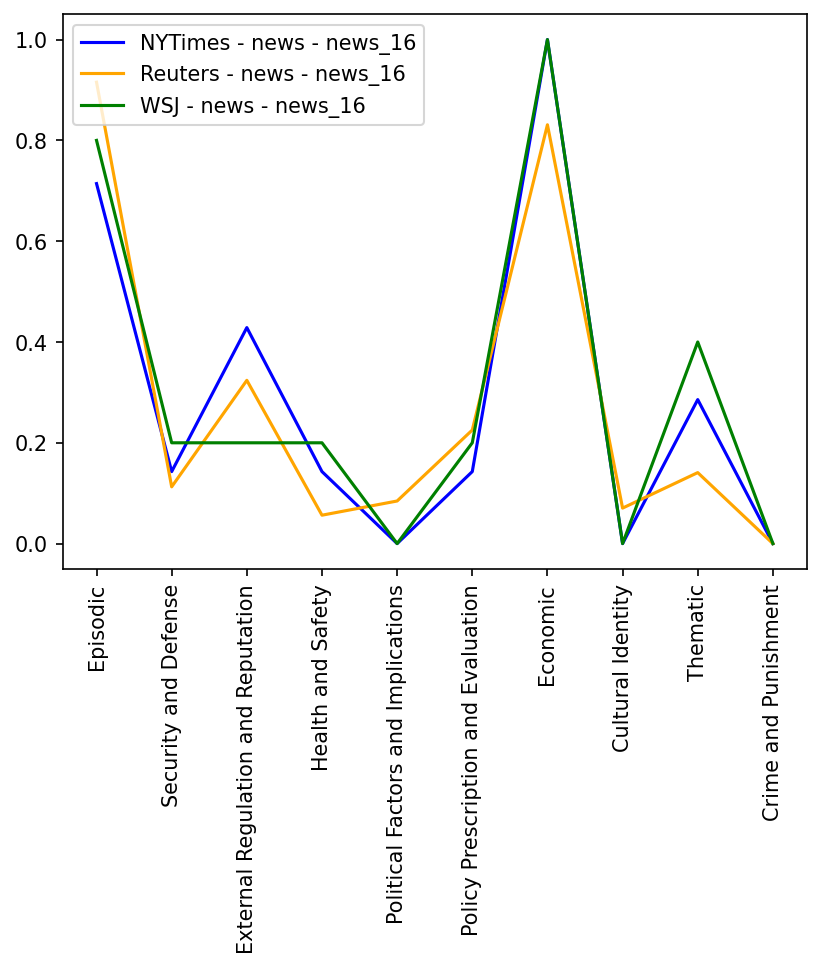

In [23]:
eval_framing(clustered_news_df[clustered_news_df['cluster_id'] == 'news_16'])

In [35]:
clustered_news_df[clustered_news_df['cluster_id'] == 'news_8']

,datetime,url,title,owner_username,cluster_id,cosine_score
967,2023-11-15 15:58:00,https://www.wsj.com/world/middle-east/iran-mai...,Iran Maintains Steady Expansion of Nuclear Pro...,WSJ,news_8,0.477568
968,2023-11-14 17:35:00,https://www.wsj.com/articles/america-needs-to-...,Opinion: U.S. Needs to Be Ready for War,WSJ,news_8,0.527404
969,2023-11-12 16:29:00,https://www.wsj.com/articles/placating-xi-wont...,Opinion: Placating Xi Won’t Change China’s Beh...,WSJ,news_8,0.441957
970,2023-11-12 08:00:00,https://www.wsj.com/world/middle-east/chinas-m...,China’s Middle East Clout Has Limits,WSJ,news_8,0.574469
971,2023-11-10 17:29:00,https://www.wsj.com/world/china-u-s-confirm-bi...,"China, U.S. Confirm Biden and Xi Will Meet in ...",WSJ,news_8,0.473128
...,...,...,...,...,...,...
1151,2023-10-18 10:02:00,/article/idUSKBN31I0OO,How Middle East tension could ripple through m...,Reuters,news_8,0.593825
1152,2023-10-18 09:54:00,/article/idUSKBN31I1DY,"Saudi Arabia, Japan agree to cooperate to ease...",Reuters,news_8,0.385699
1153,2023-10-18 06:58:00,/article/idUSP8N3AQ0DC,"Xi, Putin discuss Mideast conflict, Russia's s...",Reuters,news_8,0.650523
1154,2023-10-18 05:18:00,/article/idUSKBN31I0SC,Saudi is wild card in Middle East’s new turmoil,Reuters,news_8,0.567705


  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

,Episodic,Security and Defense,External Regulation and Reputation,Health and Safety,Political Factors and Implications,Policy Prescription and Evaluation,Economic,Cultural Identity,Thematic,Crime and Punishment
owner_username,,,,,,,,,,
NYTimes,0.750000,0.409091,0.704545,0.045455,0.272727,0.159091,0.227273,0.068182,0.340909,0.000000
Reuters,0.932773,0.386555,0.638655,0.075630,0.252101,0.201681,0.268908,0.100840,0.134454,0.042017
WSJ,0.653846,0.461538,0.538462,0.000000,0.153846,0.346154,0.115385,0.038462,0.346154,0.000000


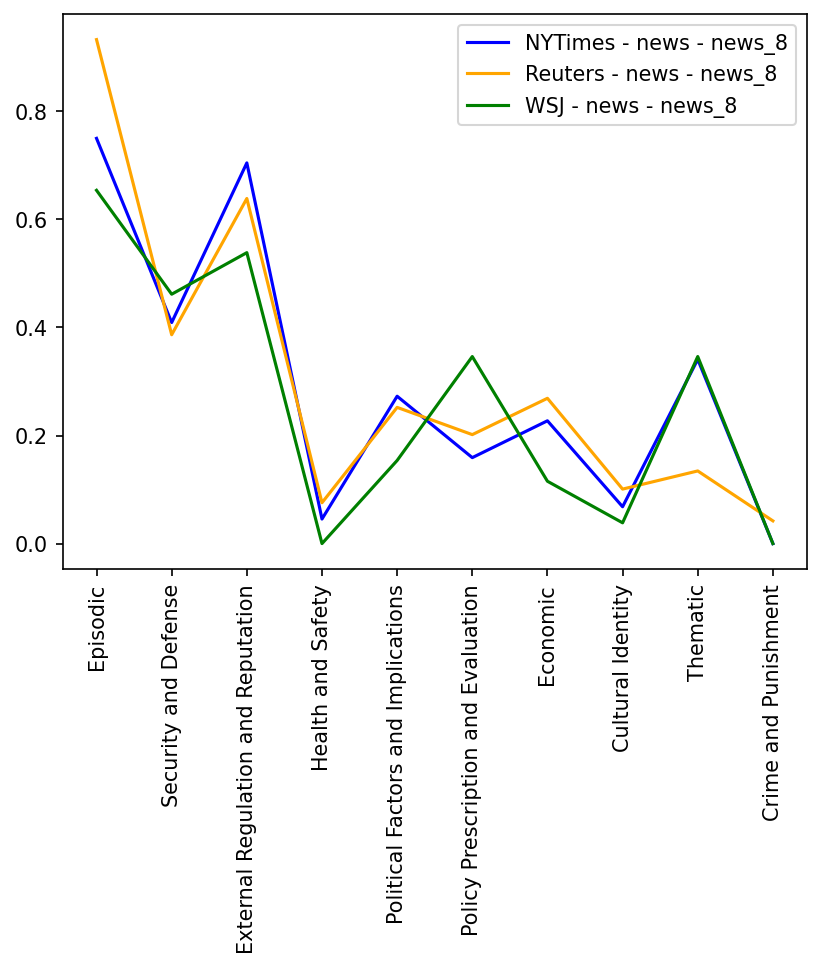

In [24]:
eval_framing(clustered_news_df[clustered_news_df['cluster_id'] == 'news_8'])

In [36]:
clustered_news_df[clustered_news_df['cluster_id'] == 'news_3']

,datetime,url,title,owner_username,cluster_id,cosine_score
1156,2023-11-15 13:58:00,https://www.wsj.com/articles/the-shock-of-faci...,Opinion: The Shock of Facing American Anti-Sem...,WSJ,news_3,0.650337
1157,2023-11-14 12:38:00,https://www.wsj.com/articles/new-york-jews-emb...,Opinion: New York Jews Embrace Gun Rights,WSJ,news_3,0.597391
1158,2023-11-13 10:00:00,https://www.wsj.com/us-news/a-town-that-has-be...,A Town That Has Been a Refuge for Jews and Mus...,WSJ,news_3,0.603149
1159,2023-11-12 10:50:00,https://www.wsj.com/articles/anti-semitism-at-...,Opinion: Anti-Semitism at Yale Requires Moral ...,WSJ,news_3,0.565476
1160,2023-11-07 17:29:00,https://www.wsj.com/articles/the-campus-anti-s...,Opinion: The Campus Anti-Semitism Problem,WSJ,news_3,0.637437
...,...,...,...,...,...,...
1344,2023-10-18 12:36:00,/article/idUSKBN31I1Q8,Meta to limit some Facebook comments on Israel...,Reuters,news_3,0.523661
1345,2023-10-18 12:32:00,/article/idUSL1N3BO1JV,Meta to limit some Facebook comments on Israel...,Reuters,news_3,0.523661
1346,2023-10-17 20:39:00,/article/idUSKBN31I01G,Trudeau says Canada faces 'scary rise' in anti...,Reuters,news_3,0.492529
1347,2023-10-17 20:37:00,/article/idUSL4N3BO032,Trudeau says Canada faces 'scary rise' in anti...,Reuters,news_3,0.492529


  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

,Episodic,Security and Defense,External Regulation and Reputation,Health and Safety,Political Factors and Implications,Policy Prescription and Evaluation,Economic,Cultural Identity,Thematic,Crime and Punishment
owner_username,,,,,,,,,,
NYTimes,0.911392,0.189873,0.088608,0.088608,0.202532,0.101266,0.037975,0.265823,0.101266,0.151899
Reuters,0.903614,0.192771,0.084337,0.084337,0.313253,0.132530,0.012048,0.204819,0.108434,0.168675
WSJ,0.870968,0.129032,0.096774,0.161290,0.129032,0.064516,0.000000,0.225806,0.161290,0.161290


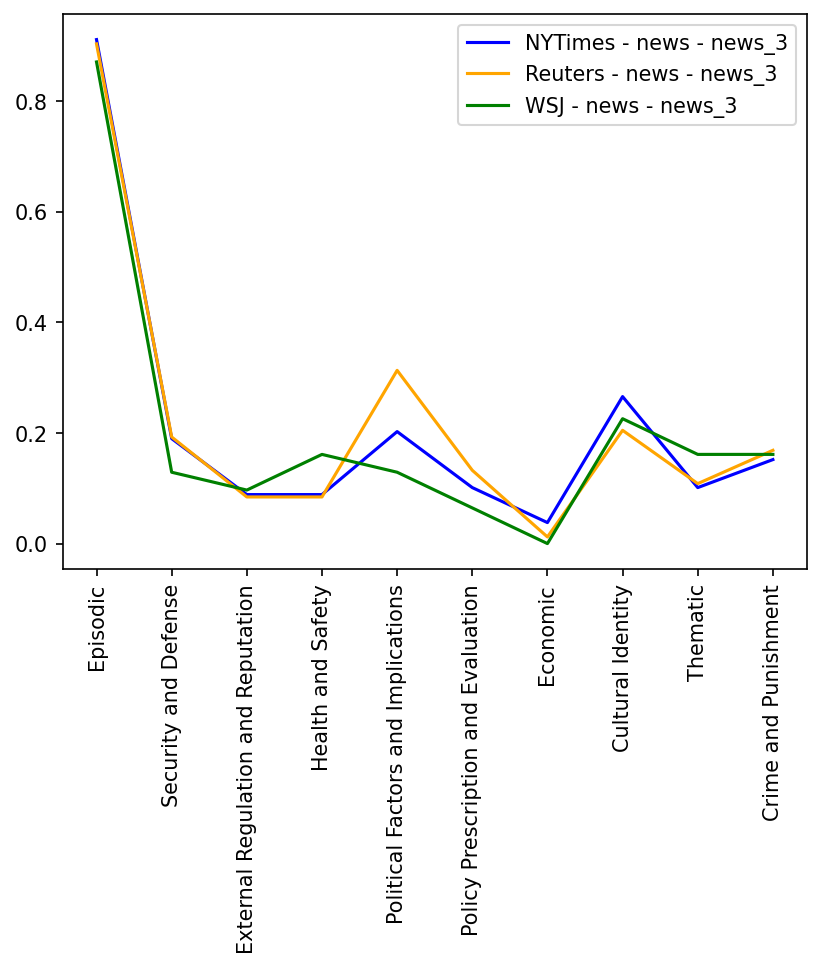

In [25]:
eval_framing(clustered_news_df[clustered_news_df['cluster_id'] == 'news_3'])

In [37]:
clustered_news_df[clustered_news_df['cluster_id'] == 'news_13']

,datetime,url,title,owner_username,cluster_id,cosine_score
1349,2023-11-14 22:09:00,https://www.wsj.com/world/middle-east/israel-h...,Israel Carries Out Targeted Operation Inside G...,WSJ,news_13,0.837694
1350,2023-11-14 18:20:00,https://www.wsj.com/articles/al-shifa-hospital...,Opinion: The Battle of Al Shifa Hospital,WSJ,news_13,0.623192
1351,2023-11-13 17:26:00,https://www.wsj.com/world/middle-east/israel-w...,Israeli Forces Reach Gate of Gaza’s Largest Ho...,WSJ,news_13,0.824082
1352,2023-11-12 20:31:00,https://www.wsj.com/world/middle-east/stricken...,Israel Pushing for Hamas to Surrender Stricken...,WSJ,news_13,0.790233
1353,2023-11-11 17:46:00,https://www.wsj.com/world/middle-east/gazas-al...,Gaza’s Al-Shifa Hospital Goes Dark at Center o...,WSJ,news_13,0.811789
...,...,...,...,...,...,...
1643,2023-10-17 17:58:00,/article/idUSKBN31H2CC,Britain will work with allies to find out what...,Reuters,news_13,0.640978
1644,2023-10-17 16:58:00,/article/idUSL1N3BN3FH,QUOTES-Reactions to strike on Gaza hospital ki...,Reuters,news_13,0.785728
1645,2023-10-17 16:52:00,/article/idUSL1N3BN394,UPDATE 2-Attack on Gaza hospital 'unprecedente...,Reuters,news_13,0.807954
1646,2023-10-17 16:49:00,/article/idUSL1N3BM2UQ,WRAPUP 13-Hundreds killed in Gaza hospital bla...,Reuters,news_13,0.645749


  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

,Episodic,Security and Defense,External Regulation and Reputation,Health and Safety,Political Factors and Implications,Policy Prescription and Evaluation,Economic,Cultural Identity,Thematic,Crime and Punishment
owner_username,,,,,,,,,,
NYTimes,0.988372,0.348837,0.046512,0.953488,0.023256,0.023256,0.011628,0.023256,0.069767,0.011628
Reuters,0.979899,0.407035,0.145729,0.994975,0.080402,0.040201,0.015075,0.035176,0.025126,0.095477
WSJ,1.000000,0.571429,0.071429,1.000000,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000


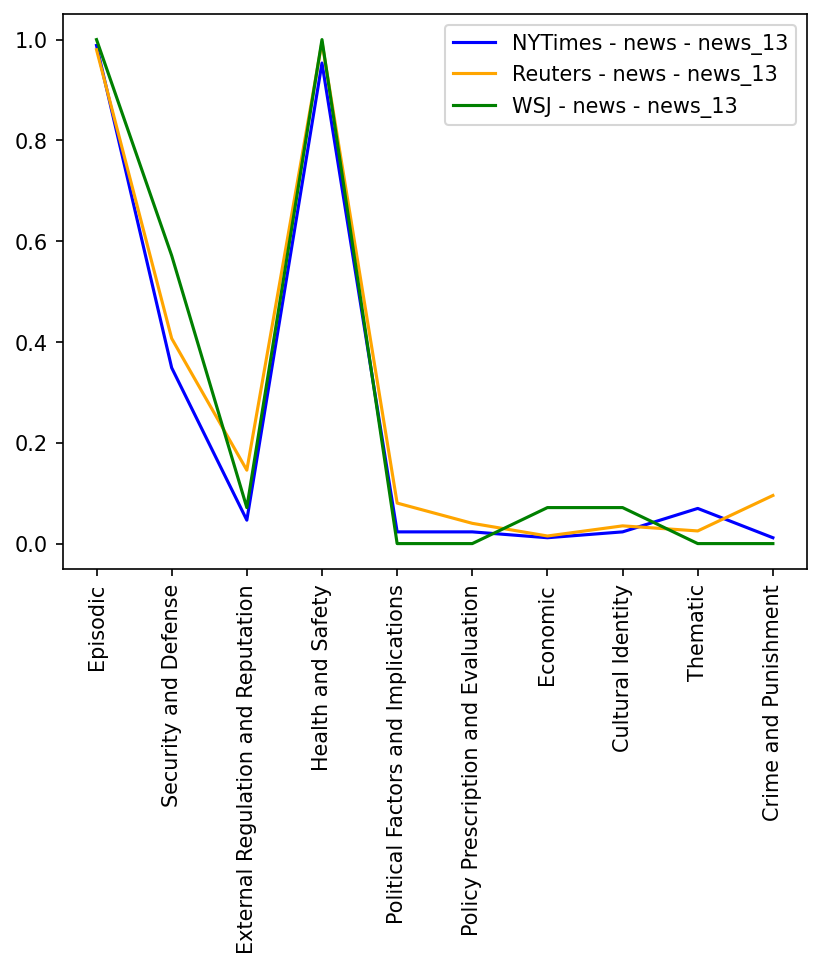

In [26]:
eval_framing(clustered_news_df[clustered_news_df['cluster_id'] == 'news_13'])

In [38]:
clustered_news_df[clustered_news_df['cluster_id'] == 'news_15']

,datetime,url,title,owner_username,cluster_id,cosine_score
1648,2023-11-14 17:31:00,https://www.wsj.com/articles/ultra-orthodox-is...,Opinion: Ultra-Orthodox Israelis Are Joining t...,WSJ,news_15,0.604811
1649,2023-11-13 11:39:00,https://www.wsj.com/articles/antony-blinken-is...,Opinion: The Day After Israeli Victory,WSJ,news_15,0.750078
1650,2023-11-08 12:40:00,https://www.wsj.com/articles/israel-biden-paus...,"Opinion: Don’t Go Wobbly on Israel Now, Joe",WSJ,news_15,0.674379
1651,2023-11-05 22:00:00,https://www.wsj.com/world/middle-east/arab-cit...,Arab Citizens of Israel Say They Face Growing ...,WSJ,news_15,0.648907
1652,2023-11-04 09:00:00,https://www.wsj.com/world/middle-east/u-s-and-...,"U.S. and Israel Split Over Gaza Goals, Muddyin...",WSJ,news_15,0.802813
...,...,...,...,...,...,...
1917,2023-10-19 07:39:00,/article/idUSKBN31J147,Israel’s fossil fuel boon becomes less clear-cut,Reuters,news_15,0.614778
1918,2023-10-18 13:21:00,/article/idUSKBN31I1SX,Analysis-Republican 2024 hopefuls use Israeli-...,Reuters,news_15,0.633854
1919,2023-10-18 13:15:00,/article/idUSL1N3BO02E,ANALYSIS-Republican 2024 hopefuls use Israeli-...,Reuters,news_15,0.663686
1920,2023-10-18 06:12:00,/article/idUSKBN31I0VO,"Fearful and grieving, Gen Z Americans clash ov...",Reuters,news_15,0.646516


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

,Episodic,Security and Defense,External Regulation and Reputation,Health and Safety,Political Factors and Implications,Policy Prescription and Evaluation,Economic,Cultural Identity,Thematic,Crime and Punishment
owner_username,,,,,,,,,,
NYTimes,0.862069,0.540230,0.183908,0.045977,0.270115,0.160920,0.051724,0.149425,0.172414,0.017241
Reuters,0.666667,0.333333,0.200000,0.066667,0.300000,0.266667,0.300000,0.200000,0.266667,0.066667
WSJ,0.757143,0.528571,0.271429,0.085714,0.214286,0.285714,0.114286,0.128571,0.300000,0.014286


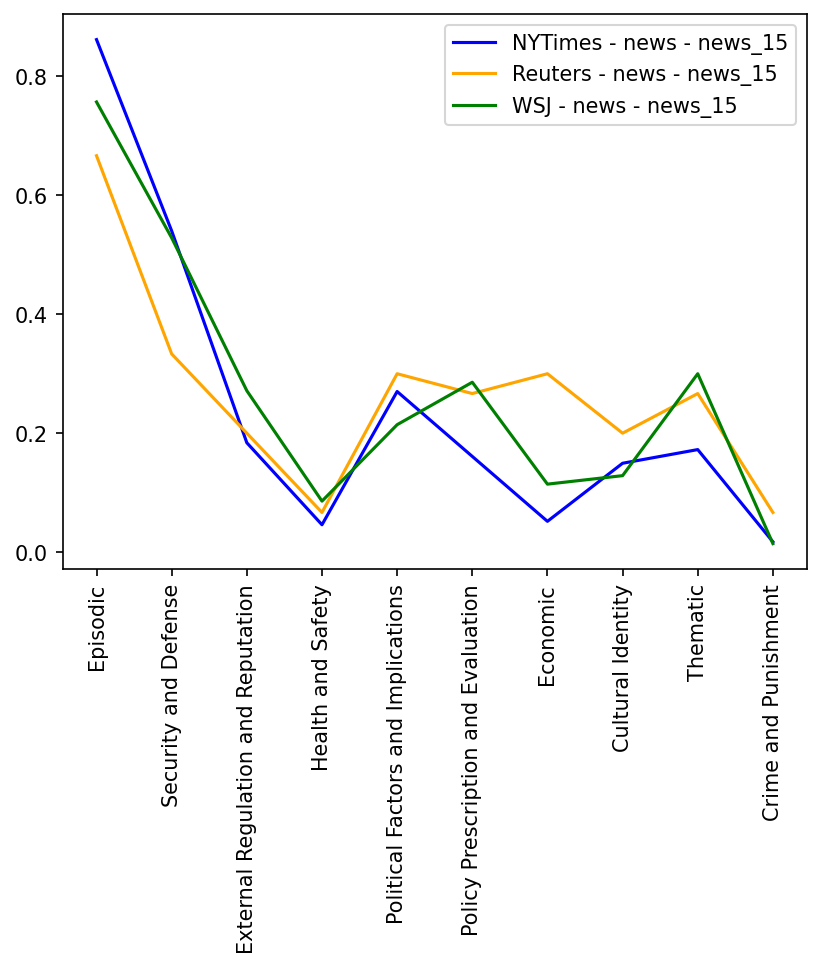

In [27]:
eval_framing(clustered_news_df[clustered_news_df['cluster_id'] == 'news_15'])

In [18]:
clustered_news_df['cluster_id'].unique()

array(['news_10', 'news_18', 'news_21', 'news_1', 'news_16', 'news_8',
       'news_3', 'news_13', 'news_15', 'news_0', 'news_19', 'news_2',
       'news_17', 'news_12', 'news_4', 'news_9', 'news_5', 'news_7',
       'news_6', 'news_22', 'news_20', 'news_11', 'news_14'], dtype=object)